In [1]:
from qTools import *

import numpy as np
import scipy
from datetime import datetime
import os
import qutip

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

import csv

-----------------------------

preface?

----------------

# Establishing the system

### Creating the Qubit and Drive Terms

In [2]:
qubit = Qubit()

# drive terms
drive_term1 = qubit.addTerm(op=sigmam)
drive_term2 = qubit.addTerm(op=sigmap)

### Setting System Parameters

In [3]:
detuning = 0
qubit.frequency = detuning

In [4]:
qubit.initialState = basis(2,0)

In [21]:
# length of pi pulse (in nanoseconds)
tpi = 25

### Simulation Parameters

In [22]:
# TODO FIND OUT PULSE LENGTH AND THEN ADJUST SIMULATION TOTAL TIME
qubit.simulation.totalTime = 2*tpi
qubit.simulation.stepSize = tpi/150
qubit.simulation.delStates = True

-----------

# Creating the drive

### Defining the objects that create the drive

NOTE: This drive is hardcoded for gaussian pulses

In [7]:
def gaussian_xi(a=1, w=1, t0=0, detuning=0, p=0, truncation=2):
    '''
    Returns xi as a guassian function of time

    Parameters:
        a           - the amplitude of the pulse
        w           - the duration of the pulse
        t0          - the start time of the pulse
        detuning    - the detuning from the perfect carrier frequency
        p           - the initial phase of the wave
        truncation  - the number of sigma by which the gaussian is truncated

    Returns:
        xi          - a function which returns the value of xi for different input times
                        (accepts int, float, and numpy.array)
                        (returns numpy.array)
    '''
   
    # function outputs xi as a function object, which itself takes a time parameter and returns the value of xi at that time
    
    def xi(time):
        # casting as an np array so the code handles all numeric data types
        time = np.array([time]).astype('float64')
        
        # any values outside of the user defined range of the gaussian are made to be NaN
        # this is so their value in the gaussian is not computed and stored
        # they will be switched to zero values after the calculation
        time[(time <= t0) | (time >= (t0 + w))] = np.nan

        # defining the y offset, y0, which will bring the edges of the guassian to 0
        y0 = np.exp(-(truncation**2))

        # truncating the standard gaussian
        out = ( (a/(1-y0))                                                  # corrected amplitude
                * ( np.exp( - ( (time-t0-w/2) / (w/(2*truncation)) )**2 )   # guassian at the correct time offset, t0, and width, w
                -y0 )                                                       # applying the y offset to bring the gaussian
                * np.exp(-1j*p)                                             # inital phase of xi
                * np.exp(-1j*2*np.pi*detuning*time)                         # rotating phase due to detuning                                          
              )
        
        # replacing all previously out of bounds values (that were set to NaN) to 0
        out = np.nan_to_num(out, 0)
        out = out[0]
        
        return out

    return xi

In [8]:
#function that determines the correct pulse amplitude OR pulse duration (when the other is fixed) for a given rotation 
def gauss_param(rot=np.pi, a=None, w=None, g=1, truncation=2):
    y0 = np.exp(-(truncation**2))
    
    if (a == None) and (w != None):
        a = rot * (1 - y0) / (4 * np.pi * g * w * (np.sqrt(np.pi) * scipy.special.erf(truncation) / (2*truncation) - y0) )
        return a
    elif w == None and (a != None):
        A = a/(1-y0)
        w = rot / (4 * np.pi * g * A * (np.sqrt(np.pi) * scipy.special.erf(truncation) / (2*truncation) - y0) )
        return w
    else:
        raise Exception('Invalid Arguments. Either a OR w should be defined.')

In [9]:
def qdrive(tpi, g=1, truncation=2, detuning=0):

    def drive_func(sequence):
        # if the user inputs only one pulse as a tuple rather than a list of tuples
        if isinstance(sequence, tuple):
            sequence = [sequence]
        
        phase_dict = {'x': 0, 'y': np.pi/2, '-x': np.pi, '-y':3*np.pi/2, 'pause':0}
        t = 0
        xi_funcs = []
        for pulse in sequence:
            # handling the phase
            if isinstance(pulse[0], str):
                if pulse[0].lower() in phase_dict.keys():
                    phase = phase_dict[pulse[0].lower()]
                else:
                    raise Exception('Invalid format')
            else:
                phase = pulse[0]
            
            #setting duration
            duration = tpi*(pulse[1]/np.pi)

            # handling the amplitude
            if pulse[0].lower() == 'pause':
                amplitude = 0
            else:
                amplitude = gauss_param(rot=pulse[1], w=duration, g=g, truncation=truncation)

            xi_funcs.append(gaussian_xi(a=amplitude, w=duration, t0=t, detuning=detuning, p=phase, truncation=truncation))

            t += duration

        def xi(time):
            # return np.sum([func(time) for func in xi_funcs])
            out = 0

            for func in xi_funcs:
                out += func(time)

            return out

        return xi

    return drive_func

-----------

# Defining Error Sweeps and Running the Simulation

### Instantiating the Sweep objects and Defining the AllXY sequences
Their sweep functions will be defined later, for each error type

In [10]:
sequence_sweep  = qubit.simulation.Sweep.createSweep(system=qubit)
t_sweep         = qubit.simulation.timeDependency.createSweep(system=qubit)

### Defining the AllXY sequences

In [11]:
AllXY = [[('pause', np.pi), ('pause', np.pi)],
         [('X', np.pi), ('X', np.pi)],
         [('Y', np.pi), ('Y', np.pi)],
         [('X', np.pi), ('Y', np.pi)],
         [('Y', np.pi), ('X', np.pi)],
         [('X', np.pi/2), ('pause', np.pi)],
         [('Y', np.pi/2), ('pause', np.pi)],
         [('X', np.pi/2), ('Y', np.pi/2)],
         [('Y', np.pi/2), ('X', np.pi/2)],
         [('X', np.pi/2), ('Y', np.pi)],
         [('Y', np.pi/2), ('X', np.pi)],
         [('X', np.pi), ('Y', np.pi/2)],
         [('Y', np.pi), ('X', np.pi/2)],
         [('X', np.pi/2), ('X', np.pi)],
         [('X', np.pi), ('X', np.pi/2)],
         [('Y', np.pi/2), ('Y', np.pi)],
         [('Y', np.pi), ('Y', np.pi/2)],
         [('X', np.pi), ('pause', np.pi)],
         [('Y', np.pi), ('pause', np.pi)],
         [('X', np.pi/2), ('X', np.pi/2)],
         [('Y', np.pi/2), ('Y', np.pi/2)]]

sequence_sweep.sweepList = AllXY

### Defining Simulation Outcomes / Measurements

In [12]:
# def measurements(sim, state):
#     # For the error simulations, only the z expectation value is important
#     # This value will be saved under the name 'z' in the results dictionary
#     sim.qRes.results['z'].append(expectationKet(sigmaz(), state))

# qubit.simulation.compute = measurements

In [12]:
def measurements2(obj):
    # For the error simulations, only the z expectation value is important
    # This value will be saved under the name 'z' in the results dictionary
    obj.qRes.results['z'].append(expectationKet(sigmaz(), obj.currentState))

qubit._freeEvol.calculate = (measurements2, 'end')

### Power Scaling Errors

In [13]:
%%time
a_scales_dB = np.arange(-1, 1+0.2, 0.2)
a_scales = 10**(a_scales_dB/20)

drive = qdrive(tpi=tpi, g=1, truncation=2, detuning=0)

a_scale_results = []

for scale in a_scales:
    def sequence_sweep_func(sweep):
        sequence = drive(sweep.sweepList[sweep.index])

        drive_coeff = lambda time: scale * sequence(time)

        def coeff_sweep(sweep):
            qubit = sweep.system
            time = qubit.simulation.stepSize * sweep.index
    
            qubit.subSys['Qubit1term2'].frequency = np.conj(drive_coeff(time))
            qubit.subSys['Qubit1term3'].frequency = drive_coeff(time)

        t_sweep.sweepFunction = coeff_sweep
        
    sequence_sweep.sweepFunction = sequence_sweep_func

    qubit.simulation.run()

    #saving results using compute function
    # results = [res[-1] for res in qubit.simulation.qRes.results['z']]
    # scale_results.append(results)

    #saving results using calculate function
    results = [res for res in qubit._freeEvol.qRes.results['z']]
    a_scale_results.append(results)

Wall time: 4min 19s


In [82]:
with open('amplitude_scaling.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(a_scale_results)

In [83]:
with open('amplitude_scaling.csv', 'r') as f:
    reader = csv.reader(f)
    a_scale_results = np.array(list(reader), dtype=float)

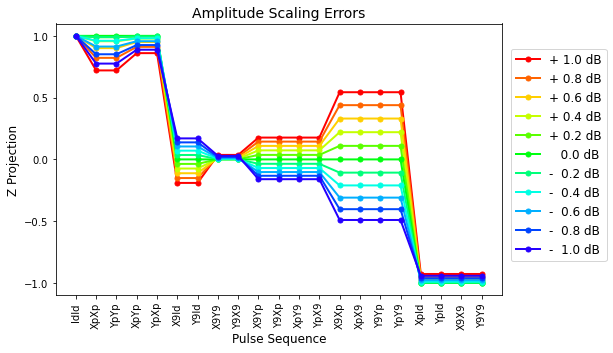

In [84]:
figure = plt.figure(figsize=(8, 5))
colours = mpl.cm.hsv(np.linspace(0, 1.4, 21))

for res, col in zip(a_scale_results[::-1], colours):
    plt.plot(res, '.-', c=col, ms=10, lw=2)

labels = [f'+ {val:.1f} dB' if val > 0 else f'-  {abs(val):.1f} dB' for val in a_scales_dB[::-1]]
labels[5] = '   0.0 dB'
plt.legend(labels=labels, loc=[1.02, 0.125], fontsize=12)
plt.xlabel('Pulse Sequence', fontsize=12)
plt.ylabel('Z Projection', fontsize=12)

xlabels = ['IdId', 'XpXp', 'YpYp', 'XpYp', 'YpXp', 'X9Id', 'Y9Id',
           'X9Y9', 'Y9X9', 'X9Yp', 'Y9Xp', 'XpY9', 'YpX9', 'X9Xp',
           'XpX9', 'Y9Yp', 'YpY9', 'XpId', 'YpId', 'X9X9', 'Y9Y9']
plt.xticks(ticks=np.arange(0, 21), labels=xlabels, rotation=90)
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Amplitude Scaling Errors', fontsize=14)
plt.show()

### Detuning Errors

In [51]:
%%time
detunings = np.arange(-0.01, 0.01+0.002, 0.002)

detuning_results = []

for detuning in detunings:
    drive = qdrive(tpi=tpi, g=1, truncation=2, detuning=detuning)
    def sequence_sweep_func(sweep):
        drive_coeff = drive(sweep.sweepList[sweep.index])

        def coeff_sweep(sweep):
            qubit = sweep.system
            time = qubit.simulation.stepSize * sweep.index
    
            qubit.subSys['Qubit1term2'].frequency = np.conj(drive_coeff(time))
            qubit.subSys['Qubit1term3'].frequency = drive_coeff(time)

        t_sweep.sweepFunction = coeff_sweep
        
    sequence_sweep.sweepFunction = sequence_sweep_func

    qubit.simulation.run()

    # # saving results using compute function
    # results = [res[-1] for res in qubit.simulation.qRes.results['z']]
    # scale_results.append(results)

    # saving results using calculate function
    results = [res for res in qubit._freeEvol.qRes.results['z']]
    detuning_results.append(results)

Wall time: 4min 39s


In [57]:
with open('detuning.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(detuning_results)

In [75]:
with open('detuning.csv', 'r') as f:
    reader = csv.reader(f)
    detuning_results1 = np.array(list(reader), dtype=float)

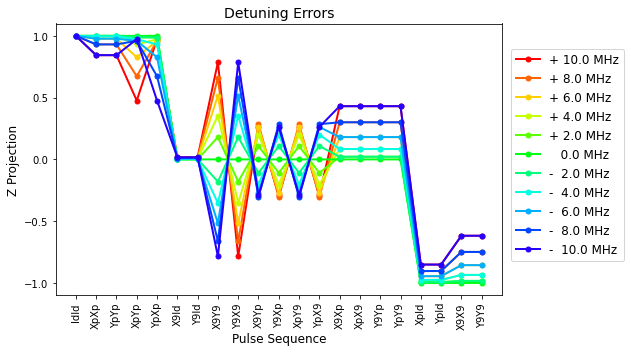

In [77]:
figure = plt.figure(figsize=(8, 5))
colours = mpl.cm.hsv(np.linspace(0, 1.4, 21))

for res, col in zip(detuning_results1[::-1], colours):
    plt.plot(res, '.-', c=col, ms=10, lw=2)

labels = [f'+ {val*1000:.1f} MHz' if val > 0 else f'-  {abs(val)*1000:.1f} MHz' for val in detunings[::-1]]
labels[5] = '   0.0 MHz'
plt.legend(labels=labels, loc=[1.02, 0.125], fontsize=12)
plt.xlabel('Pulse Sequence', fontsize=12)
plt.ylabel('Z Projection', fontsize=12)

xlabels = ['IdId', 'XpXp', 'YpYp', 'XpYp', 'YpXp', 'X9Id', 'Y9Id',
           'X9Y9', 'Y9X9', 'X9Yp', 'Y9Xp', 'XpY9', 'YpX9', 'X9Xp',
           'XpX9', 'Y9Yp', 'YpY9', 'XpId', 'YpId', 'X9X9', 'Y9Y9']
plt.xticks(ticks=np.arange(0, 21), labels=xlabels, rotation=90)
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Detuning Errors', fontsize=14)
plt.show()

### Quadrature Scaling Errors

In [54]:
%%time
q_scales = np.arange(0.95, 1.05, 0.01)

drive = qdrive(tpi=tpi, g=1, truncation=2, detuning=0)

q_scale_results = []

for scale in q_scales:
    def sequence_sweep_func(sweep):
        sequence = drive(sweep.sweepList[sweep.index])

        def coeff_sweep(sweep):
            qubit = sweep.system
            time = qubit.simulation.stepSize * sweep.index

            val = sequence(time)
            qubit.subSys['Qubit1term2'].frequency = scale*np.real(val) - np.imag(val)*1j
            qubit.subSys['Qubit1term3'].frequency = scale*np.real(val) + np.imag(val)*1j

        t_sweep.sweepFunction = coeff_sweep
        
    sequence_sweep.sweepFunction = sequence_sweep_func

    qubit.simulation.run()

    #saving results using compute function
    # results = [res[-1] for res in qubit.simulation.qRes.results['z']]
    # scale_results.append(results)

    #saving results using calculate function
    results = [res for res in qubit._freeEvol.qRes.results['z']]
    q_scale_results.append(results)

Wall time: 4min 29s


In [78]:
with open('quadrature_scaling.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(q_scale_results)

In [79]:
with open('quadrature_scaling.csv', 'r') as f:
    reader = csv.reader(f)
    q_scale_results = np.array(list(reader), dtype=float)

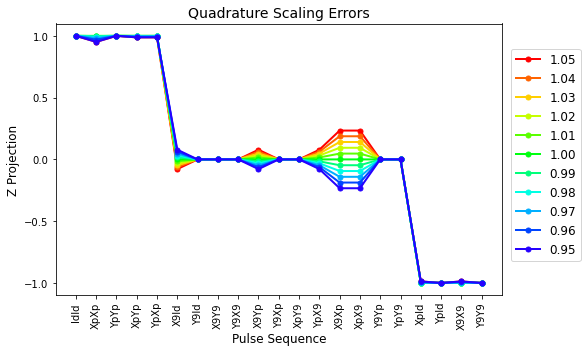

In [80]:
figure = plt.figure(figsize=(8, 5))
colours = mpl.cm.hsv(np.linspace(0, 1.4, 21))

for res, col in zip(q_scale_results[::-1], colours):
    plt.plot(res, '.-', c=col, ms=10, lw=2)

labels = [f'{val:.2f}' for val in q_scales[::-1]]
plt.legend(labels=labels, loc=[1.02, 0.125], fontsize=12)
plt.xlabel('Pulse Sequence', fontsize=12)
plt.ylabel('Z Projection', fontsize=12)

xlabels = ['IdId', 'XpXp', 'YpYp', 'XpYp', 'YpXp', 'X9Id', 'Y9Id',
           'X9Y9', 'Y9X9', 'X9Yp', 'Y9Xp', 'XpY9', 'YpX9', 'X9Xp',
           'XpX9', 'Y9Yp', 'YpY9', 'XpId', 'YpId', 'X9X9', 'Y9Y9']
plt.xticks(ticks=np.arange(0, 21), labels=xlabels, rotation=90)
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Quadrature Scaling Errors', fontsize=14)
plt.show()